In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.1/189.1 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 4.9 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=42f8180d98ce2da198d04c73ce14d488e57447f179fc8ce0c1897f340bde86dc
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools


In [3]:
import wandb

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
wandb.login()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [6]:
import tensorflow as tf
import numpy as np
import tensorflow.keras
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from PIL import Image, ImageOps
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
from tensorflow.keras.utils import load_img
from keras.layers import Dense, Flatten, BatchNormalization, Dropout
from glob import glob

from keras.applications import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19

## Loading Data

In [7]:
train_path = "/content/drive/MyDrive/files/lsdd/train"
test_path = "/content/drive/MyDrive/files/lsdd/test"
validation_path = "/content/drive/MyDrive/files/lsdd/validation"

## Vısualization

In [8]:
className = glob(train_path + "/*")
NumberofClass = len(className)
print("NumberofClass:", NumberofClass)

NumberofClass: 2


In [9]:
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen=ImageDataGenerator(rescale=1/255)
test_datagen=ImageDataGenerator(rescale=1/255)

## Data Augmentation

In [10]:
batch_size = 256
train_datagen = ImageDataGenerator(rescale=1/255,
                  shear_range=0.3,
                  horizontal_flip=True,
                  zoom_range=0.3
                  )
val_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
                train_path,
                target_size=(224,224),
                batch_size=batch_size,
                color_mode="rgb",
                class_mode="categorical"
                )

val_generator = val_datagen.flow_from_directory(
                validation_path,
                target_size=(224,224),
                batch_size=batch_size,
                color_mode="rgb",
                class_mode="categorical"
                )

Found 681 images belonging to 2 classes.
Found 145 images belonging to 2 classes.


In [11]:

test_generator = val_datagen.flow_from_directory(
                test_path,
                target_size=(224,224),
                batch_size=batch_size,
                color_mode="rgb",
                class_mode="categorical"
                )

Found 149 images belonging to 2 classes.


In [12]:
import tensorflow as tf
from sklearn.metrics import f1_score, precision_score, accuracy_score
from wandb.keras import WandbCallback

In [13]:
# initialize Wandb
wandb.init(project='lssd', name='DenseNet')
# Define the model architecture
DLM = DenseNet169(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
model = Sequential()
model.add(DLM)

# Freeze the layers of the pre-trained model
for layer in model.layers:
    layer.trainable = False

model.add(Flatten())
model.add(Dense(units=1024, activation='relu'))
model.add(Dense(units=NumberofClass, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define evaluation metrics
def f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

def precision(y_true, y_pred):
    return precision_score(y_true, y_pred, average='macro')

def accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

# Define Wandb callback for logging metrics
wandb_callback = WandbCallback(metrics=['loss', 'accuracy', 'val_loss', 'val_accuracy', 'f1', 'precision'])

# Train the model and log metrics with Wandb
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=25,
                    callbacks=[early, wandb_callback],
                    batch_size=batch_size)

wandb: Currently logged in as: cbtest201 (cbtest). Use `wandb login --relogin` to force relogin


51877672/51877672 [==============================] - 0s 0us/step


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/25
3/3 [==============================] - ETA: 0s - loss: 43.7565 - accuracy: 0.5932 

wandb: Adding directory to artifact (/content/wandb/run-20230324_154732-no0yz33w/files/model-best)... Done. 5.9s



3/3 [==============================] - 223s 75s/step - loss: 43.7565 - accuracy: 0.5932 - val_loss: 40.8984 - val_accuracy: 0.7172
Epoch 2/25
3/3 [==============================] - ETA: 0s - loss: 30.3635 - accuracy: 0.7151

wandb: Adding directory to artifact (/content/wandb/run-20230324_154732-no0yz33w/files/model-best)... Done. 5.7s



3/3 [==============================] - 106s 50s/step - loss: 30.3635 - accuracy: 0.7151 - val_loss: 6.2742 - val_accuracy: 0.7517
Epoch 3/25
3/3 [==============================] - 18s 7s/step - loss: 6.0694 - accuracy: 0.6931 - val_loss: 7.0401 - val_accuracy: 0.6552
Epoch 4/25
3/3 [==============================] - ETA: 0s - loss: 3.7608 - accuracy: 0.7988

wandb: Adding directory to artifact (/content/wandb/run-20230324_154732-no0yz33w/files/model-best)... Done. 5.8s



3/3 [==============================] - 99s 47s/step - loss: 3.7608 - accuracy: 0.7988 - val_loss: 5.5209 - val_accuracy: 0.7862
Epoch 5/25
3/3 [==============================] - ETA: 0s - loss: 3.4005 - accuracy: 0.8399

wandb: Adding directory to artifact (/content/wandb/run-20230324_154732-no0yz33w/files/model-best)... Done. 5.7s



3/3 [==============================] - 107s 51s/step - loss: 3.4005 - accuracy: 0.8399 - val_loss: 2.2963 - val_accuracy: 0.8690
Epoch 6/25
3/3 [==============================] - ETA: 0s - loss: 0.9772 - accuracy: 0.9178

wandb: Adding directory to artifact (/content/wandb/run-20230324_154732-no0yz33w/files/model-best)... Done. 5.8s



3/3 [==============================] - 106s 51s/step - loss: 0.9772 - accuracy: 0.9178 - val_loss: 2.1362 - val_accuracy: 0.8345
Epoch 7/25
3/3 [==============================] - ETA: 0s - loss: 1.3238 - accuracy: 0.8899

wandb: Adding directory to artifact (/content/wandb/run-20230324_154732-no0yz33w/files/model-best)... Done. 6.0s



3/3 [==============================] - 104s 50s/step - loss: 1.3238 - accuracy: 0.8899 - val_loss: 1.6886 - val_accuracy: 0.8621
Epoch 8/25
3/3 [==============================] - ETA: 0s - loss: 0.6864 - accuracy: 0.9266

wandb: Adding directory to artifact (/content/wandb/run-20230324_154732-no0yz33w/files/model-best)... Done. 5.7s



3/3 [==============================] - 103s 50s/step - loss: 0.6864 - accuracy: 0.9266 - val_loss: 1.4083 - val_accuracy: 0.9103
Epoch 9/25
3/3 [==============================] - ETA: 0s - loss: 0.8745 - accuracy: 0.9134

wandb: Adding directory to artifact (/content/wandb/run-20230324_154732-no0yz33w/files/model-best)... Done. 5.7s



3/3 [==============================] - 103s 50s/step - loss: 0.8745 - accuracy: 0.9134 - val_loss: 1.3814 - val_accuracy: 0.9034
Epoch 10/25
3/3 [==============================] - ETA: 0s - loss: 0.4764 - accuracy: 0.9295

wandb: Adding directory to artifact (/content/wandb/run-20230324_154732-no0yz33w/files/model-best)... Done. 6.0s



3/3 [==============================] - 106s 49s/step - loss: 0.4764 - accuracy: 0.9295 - val_loss: 0.9565 - val_accuracy: 0.9034
Epoch 11/25
3/3 [==============================] - 17s 6s/step - loss: 0.4270 - accuracy: 0.9442 - val_loss: 0.9983 - val_accuracy: 0.8897
Epoch 12/25
3/3 [==============================] - ETA: 0s - loss: 0.2667 - accuracy: 0.9589

wandb: Adding directory to artifact (/content/wandb/run-20230324_154732-no0yz33w/files/model-best)... Done. 6.0s



3/3 [==============================] - 100s 48s/step - loss: 0.2667 - accuracy: 0.9589 - val_loss: 0.7929 - val_accuracy: 0.9172
Epoch 13/25
3/3 [==============================] - 14s 5s/step - loss: 0.2277 - accuracy: 0.9604 - val_loss: 0.9039 - val_accuracy: 0.9103
Epoch 14/25
3/3 [==============================] - ETA: 0s - loss: 0.2424 - accuracy: 0.9604

wandb: Adding directory to artifact (/content/wandb/run-20230324_154732-no0yz33w/files/model-best)... Done. 5.7s



3/3 [==============================] - 100s 47s/step - loss: 0.2424 - accuracy: 0.9604 - val_loss: 0.7660 - val_accuracy: 0.9241
Epoch 15/25
3/3 [==============================] - ETA: 0s - loss: 0.1694 - accuracy: 0.9648

wandb: Adding directory to artifact (/content/wandb/run-20230324_154732-no0yz33w/files/model-best)... Done. 5.8s



3/3 [==============================] - 104s 49s/step - loss: 0.1694 - accuracy: 0.9648 - val_loss: 0.7267 - val_accuracy: 0.8897
Epoch 16/25
3/3 [==============================] - ETA: 0s - loss: 0.1728 - accuracy: 0.9589

wandb: Adding directory to artifact (/content/wandb/run-20230324_154732-no0yz33w/files/model-best)... Done. 6.0s



3/3 [==============================] - 104s 50s/step - loss: 0.1728 - accuracy: 0.9589 - val_loss: 0.6954 - val_accuracy: 0.9034
Epoch 17/25
3/3 [==============================] - ETA: 0s - loss: 0.1064 - accuracy: 0.9736

wandb: Adding directory to artifact (/content/wandb/run-20230324_154732-no0yz33w/files/model-best)... Done. 5.8s



3/3 [==============================] - 105s 50s/step - loss: 0.1064 - accuracy: 0.9736 - val_loss: 0.6821 - val_accuracy: 0.9172
Epoch 18/25
3/3 [==============================] - ETA: 0s - loss: 0.1164 - accuracy: 0.9721

wandb: Adding directory to artifact (/content/wandb/run-20230324_154732-no0yz33w/files/model-best)... Done. 5.9s



3/3 [==============================] - 107s 50s/step - loss: 0.1164 - accuracy: 0.9721 - val_loss: 0.6643 - val_accuracy: 0.9241
Epoch 19/25
3/3 [==============================] - ETA: 0s - loss: 0.0681 - accuracy: 0.9809

wandb: Adding directory to artifact (/content/wandb/run-20230324_154732-no0yz33w/files/model-best)... Done. 5.8s



3/3 [==============================] - 107s 52s/step - loss: 0.0681 - accuracy: 0.9809 - val_loss: 0.6287 - val_accuracy: 0.8966
Epoch 20/25
3/3 [==============================] - ETA: 0s - loss: 0.0767 - accuracy: 0.9794

wandb: Adding directory to artifact (/content/wandb/run-20230324_154732-no0yz33w/files/model-best)... Done. 6.0s



3/3 [==============================] - 107s 50s/step - loss: 0.0767 - accuracy: 0.9794 - val_loss: 0.6117 - val_accuracy: 0.8966
Epoch 21/25
3/3 [==============================] - ETA: 0s - loss: 0.0744 - accuracy: 0.9809

wandb: Adding directory to artifact (/content/wandb/run-20230324_154732-no0yz33w/files/model-best)... Done. 5.7s



3/3 [==============================] - 105s 50s/step - loss: 0.0744 - accuracy: 0.9809 - val_loss: 0.5895 - val_accuracy: 0.9103
Epoch 22/25
3/3 [==============================] - ETA: 0s - loss: 0.0597 - accuracy: 0.9794

wandb: Adding directory to artifact (/content/wandb/run-20230324_154732-no0yz33w/files/model-best)... Done. 5.7s



3/3 [==============================] - 105s 49s/step - loss: 0.0597 - accuracy: 0.9794 - val_loss: 0.5786 - val_accuracy: 0.9103
Epoch 23/25
3/3 [==============================] - ETA: 0s - loss: 0.0276 - accuracy: 0.9912

wandb: Adding directory to artifact (/content/wandb/run-20230324_154732-no0yz33w/files/model-best)... Done. 6.0s



3/3 [==============================] - 103s 49s/step - loss: 0.0276 - accuracy: 0.9912 - val_loss: 0.5750 - val_accuracy: 0.9103
Epoch 24/25
3/3 [==============================] - ETA: 0s - loss: 0.0364 - accuracy: 0.9883

wandb: Adding directory to artifact (/content/wandb/run-20230324_154732-no0yz33w/files/model-best)... Done. 5.8s



3/3 [==============================] - 104s 49s/step - loss: 0.0364 - accuracy: 0.9883 - val_loss: 0.5603 - val_accuracy: 0.9103
Epoch 25/25
3/3 [==============================] - ETA: 0s - loss: 0.0543 - accuracy: 0.9853

wandb: Adding directory to artifact (/content/wandb/run-20230324_154732-no0yz33w/files/model-best)... Done. 5.7s



3/3 [==============================] - 104s 49s/step - loss: 0.0543 - accuracy: 0.9853 - val_loss: 0.5543 - val_accuracy: 0.9103


In [14]:
# Evaluate the model on the validation data
val_pred = model.predict(val_generator)
val_true = val_generator.classes
val_pred = tf.argmax(val_pred, axis=1)

val_accuracy = accuracy(val_true, val_pred)
val_f1 = f1(val_true, val_pred)
val_precision = precision(val_true, val_pred)

# Log the evaluation metrics with Wandb
wandb.log({'val_accuracy': val_accuracy, 'f1': val_f1, 'precision': val_precision})

1/1 [==============================] - 5s 5s/step


## Evaluating the Model

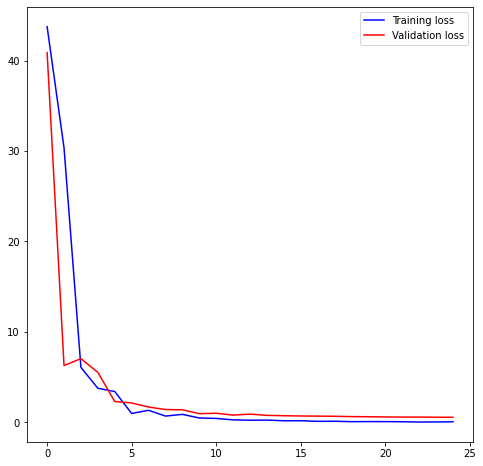

<Figure size 432x288 with 0 Axes>

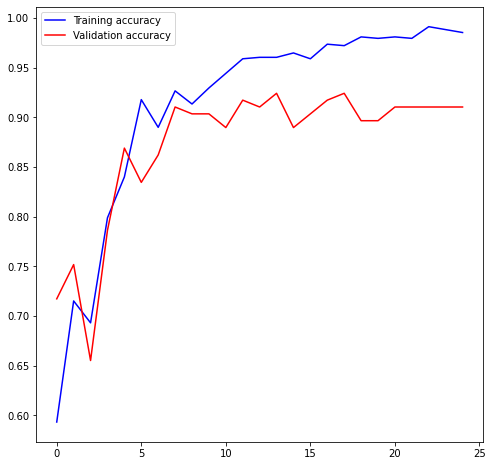

In [15]:
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="Validation loss")
plt.legend()
plt.show()

plt.figure()

plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend()
plt.show()

In [16]:
model.evaluate(test_generator)

1/1 [==============================] - 8s 8s/step - loss: 0.6200 - accuracy: 0.9262


[0.620037853717804, 0.926174521446228]

In [17]:
# initialize Wandb
wandb.init(project='lssd', name='VGG16')
# Define the model architecture
DLM = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
model = Sequential()
model.add(DLM)

# Freeze the layers of the pre-trained model
for layer in model.layers:
    layer.trainable = False

model.add(Flatten())
model.add(Dense(units=1024, activation='relu'))
model.add(Dense(units=NumberofClass, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define evaluation metrics
def f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

def precision(y_true, y_pred):
    return precision_score(y_true, y_pred, average='macro')

def accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

# Define Wandb callback for logging metrics
wandb_callback = WandbCallback(metrics=['loss', 'accuracy', 'val_loss', 'val_accuracy', 'f1', 'precision'])

# Train the model and log metrics with Wandb
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=25,
                    callbacks=[early, wandb_callback],
                    batch_size=batch_size)

accuracy,▁▃▃▅▅▇▆▇▇▇▇▇▇▇█▇█████████
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
f1,▁
loss,█▆▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁
val_accuracy,▄▄▃▅▇▆▇███▇███▇███▇▇█████▁
val_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.98532
best_epoch,24
best_val_loss,0.55426
epoch,24


58889256/58889256 [==============================] - 1s 0us/step
Epoch 1/25
3/3 [==============================] - ETA: 0s - loss: 18.5430 - accuracy: 0.6167 

wandb: Adding directory to artifact (/content/wandb/run-20230324_163233-ydwkornn/files/model-best)... Done. 1.9s



3/3 [==============================] - 69s 25s/step - loss: 18.5430 - accuracy: 0.6167 - val_loss: 12.7866 - val_accuracy: 0.7172
Epoch 2/25
3/3 [==============================] - ETA: 0s - loss: 5.3181 - accuracy: 0.7269

wandb: Adding directory to artifact (/content/wandb/run-20230324_163233-ydwkornn/files/model-best)... Done. 1.8s



3/3 [==============================] - 19s 8s/step - loss: 5.3181 - accuracy: 0.7269 - val_loss: 4.5410 - val_accuracy: 0.2897
Epoch 3/25
3/3 [==============================] - ETA: 0s - loss: 1.8897 - accuracy: 0.5624

wandb: Adding directory to artifact (/content/wandb/run-20230324_163233-ydwkornn/files/model-best)... Done. 2.2s



3/3 [==============================] - 22s 9s/step - loss: 1.8897 - accuracy: 0.5624 - val_loss: 1.3268 - val_accuracy: 0.7172
Epoch 4/25
3/3 [==============================] - ETA: 0s - loss: 1.6345 - accuracy: 0.7195

wandb: Adding directory to artifact (/content/wandb/run-20230324_163233-ydwkornn/files/model-best)... Done. 1.9s



3/3 [==============================] - 22s 9s/step - loss: 1.6345 - accuracy: 0.7195 - val_loss: 0.7329 - val_accuracy: 0.7862
Epoch 5/25
3/3 [==============================] - 14s 5s/step - loss: 0.6764 - accuracy: 0.7856 - val_loss: 1.0943 - val_accuracy: 0.6759
Epoch 6/25
3/3 [==============================] - ETA: 0s - loss: 0.6752 - accuracy: 0.7827

wandb: Adding directory to artifact (/content/wandb/run-20230324_163233-ydwkornn/files/model-best)... Done. 2.0s



3/3 [==============================] - 20s 7s/step - loss: 0.6752 - accuracy: 0.7827 - val_loss: 0.3070 - val_accuracy: 0.8966
Epoch 7/25
3/3 [==============================] - 13s 5s/step - loss: 0.4424 - accuracy: 0.8473 - val_loss: 0.5074 - val_accuracy: 0.8483
Epoch 8/25
3/3 [==============================] - ETA: 0s - loss: 0.4204 - accuracy: 0.8517

wandb: Adding directory to artifact (/content/wandb/run-20230324_163233-ydwkornn/files/model-best)... Done. 1.9s



3/3 [==============================] - 19s 8s/step - loss: 0.4204 - accuracy: 0.8517 - val_loss: 0.2887 - val_accuracy: 0.8966
Epoch 9/25
3/3 [==============================] - 14s 4s/step - loss: 0.3029 - accuracy: 0.8811 - val_loss: 0.3859 - val_accuracy: 0.8621
Epoch 10/25
3/3 [==============================] - ETA: 0s - loss: 0.2623 - accuracy: 0.8913

wandb: Adding directory to artifact (/content/wandb/run-20230324_163233-ydwkornn/files/model-best)... Done. 1.9s



3/3 [==============================] - 20s 8s/step - loss: 0.2623 - accuracy: 0.8913 - val_loss: 0.2474 - val_accuracy: 0.9034
Epoch 11/25
3/3 [==============================] - ETA: 0s - loss: 0.2060 - accuracy: 0.9178

wandb: Adding directory to artifact (/content/wandb/run-20230324_163233-ydwkornn/files/model-best)... Done. 1.9s



3/3 [==============================] - 22s 8s/step - loss: 0.2060 - accuracy: 0.9178 - val_loss: 0.2181 - val_accuracy: 0.8897
Epoch 12/25
3/3 [==============================] - 14s 5s/step - loss: 0.1903 - accuracy: 0.9266 - val_loss: 0.2279 - val_accuracy: 0.9034
Epoch 13/25
3/3 [==============================] - 12s 5s/step - loss: 0.1696 - accuracy: 0.9369 - val_loss: 0.2202 - val_accuracy: 0.9103
Epoch 14/25
3/3 [==============================] - ETA: 0s - loss: 0.1679 - accuracy: 0.9383

wandb: Adding directory to artifact (/content/wandb/run-20230324_163233-ydwkornn/files/model-best)... Done. 1.8s



3/3 [==============================] - 19s 7s/step - loss: 0.1679 - accuracy: 0.9383 - val_loss: 0.2066 - val_accuracy: 0.8966
Epoch 15/25
3/3 [==============================] - ETA: 0s - loss: 0.1464 - accuracy: 0.9457

wandb: Adding directory to artifact (/content/wandb/run-20230324_163233-ydwkornn/files/model-best)... Done. 1.9s



3/3 [==============================] - 22s 8s/step - loss: 0.1464 - accuracy: 0.9457 - val_loss: 0.2043 - val_accuracy: 0.9172
Epoch 16/25
3/3 [==============================] - ETA: 0s - loss: 0.1499 - accuracy: 0.9457

wandb: Adding directory to artifact (/content/wandb/run-20230324_163233-ydwkornn/files/model-best)... Done. 1.7s



3/3 [==============================] - 20s 8s/step - loss: 0.1499 - accuracy: 0.9457 - val_loss: 0.2029 - val_accuracy: 0.9034
Epoch 17/25
3/3 [==============================] - 14s 5s/step - loss: 0.1300 - accuracy: 0.9442 - val_loss: 0.2045 - val_accuracy: 0.9034
Epoch 18/25
3/3 [==============================] - 13s 5s/step - loss: 0.1356 - accuracy: 0.9486 - val_loss: 0.2059 - val_accuracy: 0.9103
Epoch 19/25
3/3 [==============================] - 12s 4s/step - loss: 0.1166 - accuracy: 0.9633 - val_loss: 0.2097 - val_accuracy: 0.9103
Epoch 20/25
3/3 [==============================] - 11s 4s/step - loss: 0.1071 - accuracy: 0.9604 - val_loss: 0.2131 - val_accuracy: 0.9034
Epoch 21/25
3/3 [==============================] - 13s 4s/step - loss: 0.1052 - accuracy: 0.9692 - val_loss: 0.2143 - val_accuracy: 0.9103


In [18]:
# Evaluate the model on the validation data
val_pred = model.predict(val_generator)
val_true = val_generator.classes
val_pred = tf.argmax(val_pred, axis=1)

val_accuracy = accuracy(val_true, val_pred)
val_f1 = f1(val_true, val_pred)
val_precision = precision(val_true, val_pred)

# Log the evaluation metrics with Wandb
wandb.log({'val_accuracy': val_accuracy, 'f1': val_f1, 'precision': val_precision})

1/1 [==============================] - 1s 836ms/step


## Evaluating the Model

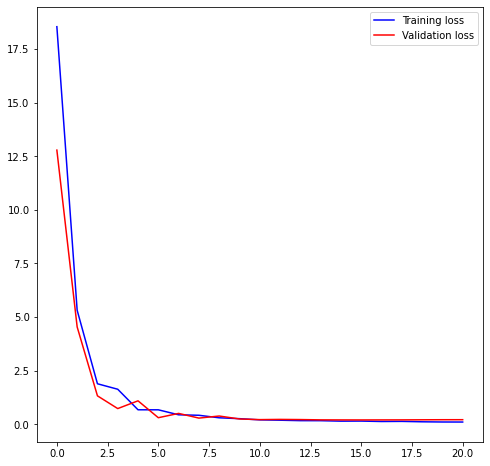

<Figure size 432x288 with 0 Axes>

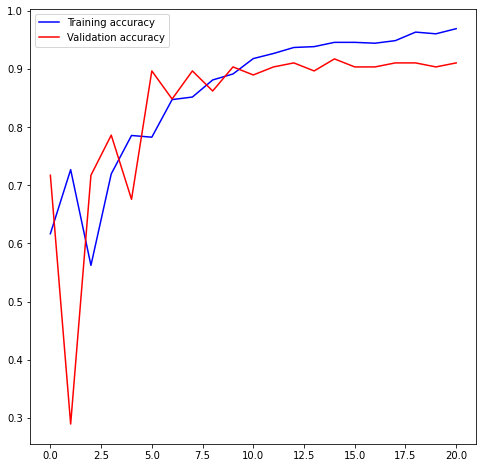

In [19]:
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="Validation loss")
plt.legend()
plt.show()

plt.figure()

plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend()
plt.show()

In [20]:
model.evaluate(test_generator)

1/1 [==============================] - 14s 14s/step - loss: 0.3266 - accuracy: 0.9128


[0.326620876789093, 0.9127516746520996]

In [25]:
batch_size = 256
train_datagen = ImageDataGenerator(rescale=1/255,
                  shear_range=0.3,
                  horizontal_flip=True,
                  zoom_range=0.3
                  )
val_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
                train_path,
                target_size=(299,299),
                batch_size=batch_size,
                color_mode="rgb",
                class_mode="categorical"
                )

val_generator = val_datagen.flow_from_directory(
                validation_path,
                target_size=(299,299),
                batch_size=batch_size,
                color_mode="rgb",
                class_mode="categorical"
                )

Found 681 images belonging to 2 classes.
Found 145 images belonging to 2 classes.


In [26]:

test_generator = val_datagen.flow_from_directory(
                test_path,
                target_size=(299,299),
                batch_size=batch_size,
                color_mode="rgb",
                class_mode="categorical"
                )

Found 149 images belonging to 2 classes.


In [ ]:
# initialize Wandb
wandb.init(project='lssd', name='InceptionV3')
# Define the model architecture
DLM = InceptionV3(include_top=False, weights="imagenet", input_shape=(299, 299, 3))
model = Sequential()
model.add(DLM)

# Freeze the layers of the pre-trained model
for layer in model.layers:
    layer.trainable = False

model.add(Flatten())
model.add(Dense(units=1024, activation='relu'))
model.add(Dense(units=NumberofClass, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define evaluation metrics
def f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

def precision(y_true, y_pred):
    return precision_score(y_true, y_pred, average='macro')

def accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

# Define Wandb callback for logging metrics
wandb_callback = WandbCallback(metrics=['loss', 'accuracy', 'val_loss', 'val_accuracy', 'f1', 'precision'])

# Train the model and log metrics with Wandb
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=25,
                    callbacks=[early, wandb_callback],
                    batch_size=batch_size)

In [34]:
# !rm -rf /content/wandb/run-20230324_165416-tlocsl3h

In [ ]:
# Evaluate the model on the validation data
val_pred = model.predict(val_generator)
val_true = val_generator.classes
val_pred = tf.argmax(val_pred, axis=1)

val_accuracy = accuracy(val_true, val_pred)
val_f1 = f1(val_true, val_pred)
val_precision = precision(val_true, val_pred)

# Log the evaluation metrics with Wandb
wandb.log({'val_accuracy': val_accuracy, 'f1': val_f1, 'precision': val_precision})

## Evaluating the Model

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="Validation loss")
plt.legend()
plt.show()

plt.figure()

plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_generator)

In [ ]:
# saving and loading the .h5 model

# save model
# model.save('/content/drive/MyDrive/incv31.h5')
# print('Model Saved!')

# load model
# savedModel=load_model('incv31.h5')
# savedModel.summary()
